In [1]:
import pandas as pd
import numpy as np
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from itertools import product
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import lightgbm as lgb

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')
tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')

In [4]:
np.sort(
    tests['shop_id'].unique()
)

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
all_sales = sales.merge(items).merge(item_cats).merge(shops)
all_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
...,...,...,...,...,...,...,...,...,...,...
2935844,22.10.2015,33,55,13093,250.0,1.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935845,21.09.2015,32,55,13091,1000.0,1.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935846,16.09.2015,32,55,13094,2500.0,1.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935847,22.09.2015,32,55,13094,2500.0,2.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн


In [7]:
sales.shape

(2935849, 6)

In [8]:
## And use only 3 shops for simplicity.
# sales = sales[sales['shop_id'].isin([26, 27, 28])]
# tests = tests[tests['shop_id'].isin([26, 27, 28])]

In [9]:
# Remove outliers
sales = sales[sales['item_price']<100000]
sales = sales[sales['item_cnt_day']<1001]

In [10]:
del sales

In [11]:
all_sales = all_sales[all_sales['item_price']<100000]
all_sales = all_sales[all_sales['item_cnt_day']<1001]

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [12]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in all_sales['date_block_num'].unique():
    cur_shops = all_sales.loc[all_sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = all_sales.loc[all_sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,21759,0
2,59,21347,0
3,59,22015,0
4,59,18977,0
...,...,...,...
10913799,55,5007,33
10913800,55,7115,33
10913801,55,13095,33
10913802,55,13093,33


In [13]:
## Append test date to our grid
tests['date_block_num'] = 34
grid = grid.append(tests.drop(columns=['ID']), ignore_index=True)
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,21759,0
2,59,21347,0
3,59,22015,0
4,59,18977,0
...,...,...,...
11127999,45,18454,34
11128000,45,16188,34
11128001,45,15757,34
11128002,45,19648,34


In [14]:
grid = grid.merge(items[['item_id', 'item_category_id']], how='left', on=['item_id'])
# index_cols = grid.columns
grid

,shop_id,item_id,date_block_num,item_category_id
0,59,22154,0,37
1,59,21759,0,37
2,59,21347,0,37
3,59,22015,0,37
4,59,18977,0,37
...,...,...,...,...
11127999,45,18454,34,55
11128000,45,16188,34,64
11128001,45,15757,34,55
11128002,45,19648,34,40


In [15]:
%%time
# Groupby data to get shop-item-month aggregates
gb = all_sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target'}, inplace=True)
# gb.clip(0, 20, inplace=True)
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
# Clipping target range to 0..20
all_data['target'].clip(lower=0, upper=20, inplace=True)
all_data

CPU times: user 3.48 s, sys: 775 ms, total: 4.26 s
Wall time: 4.18 s


,shop_id,item_id,date_block_num,item_category_id,target
0,59,22154,0,37,1.0
1,59,21759,0,37,1.0
2,59,21347,0,37,1.0
3,59,22015,0,37,1.0
4,59,18977,0,37,1.0
...,...,...,...,...,...
11127999,45,18454,34,55,0.0
11128000,45,16188,34,64,0.0
11128001,45,15757,34,55,0.0
11128002,45,19648,34,40,0.0


In [16]:
%%time
# Same as above but with shop-month aggregates
gb = all_sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_shop_date'}, inplace=True)                                                                
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data

# Same as above but with item-month aggregates
gb = all_sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_item_date'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with item-shop-month aggregates
gb = all_sales.groupby(['item_id', 'shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_item_shop_date'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'shop_id', 'date_block_num']).fillna(0)

# 
gb = all_sales.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_item-cat_date'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
all_data

# 
gb = all_sales.groupby(['shop_id', 'item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'target_shop_item-cat_date'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'item_category_id', 'date_block_num']).fillna(0)
all_data

CPU times: user 9.85 s, sys: 2.19 s, total: 12 s
Wall time: 12 s


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date
0,59,22154,0,37,1.0,2017.0,18.0,1.0,6094.0,60.0
1,59,21759,0,37,1.0,2017.0,8.0,1.0,6094.0,60.0
2,59,21347,0,37,1.0,2017.0,14.0,1.0,6094.0,60.0
3,59,22015,0,37,1.0,2017.0,62.0,1.0,6094.0,60.0
4,59,18977,0,37,1.0,2017.0,50.0,1.0,6094.0,60.0
...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0
11128000,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0
11128001,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0
11128002,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [18]:
print('Shape of "all_data":', all_data.shape[0], 'rows,', all_data.shape[1], 'columns')
all_data

Shape of "all_data": 11128004 rows, 10 columns


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date
0,59,22154,0,37,1.0,2017.0,18.0,1.0,6094.0,60.0
1,59,21759,0,37,1.0,2017.0,8.0,1.0,6094.0,60.0
2,59,21347,0,37,1.0,2017.0,14.0,1.0,6094.0,60.0
3,59,22015,0,37,1.0,2017.0,62.0,1.0,6094.0,60.0
4,59,18977,0,37,1.0,2017.0,50.0,1.0,6094.0,60.0
...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0
11128000,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0
11128001,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0
11128002,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
all_data.to_parquet('data/all_data_first.parquet', index=True)

In [20]:
all_data = pd.read_parquet('data/all_data_first.parquet')

In [21]:
%%time
# Mean encoded features
column = all_data.groupby(['date_block_num']).agg('target').mean().astype('float32').to_frame().rename(
    columns={'target':'target_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['date_block_num'], how='left')
all_data

CPU times: user 988 ms, sys: 323 ms, total: 1.31 s
Wall time: 1.23 s


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,target_mean
0,59,22154,0,37,1.0,2017.0,18.0,1.0,6094.0,60.0,0.347176
1,59,21759,0,37,1.0,2017.0,8.0,1.0,6094.0,60.0,0.347176
2,59,21347,0,37,1.0,2017.0,14.0,1.0,6094.0,60.0,0.347176
3,59,22015,0,37,1.0,2017.0,62.0,1.0,6094.0,60.0,0.347176
4,59,18977,0,37,1.0,2017.0,50.0,1.0,6094.0,60.0,0.347176
...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11128000,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11128001,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11128002,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [22]:
%%time
column = all_data.groupby(['shop_id', 'date_block_num']).agg('target_shop_date').mean().astype('float32').to_frame().rename(
    columns={'target_shop_date':'target_shop_date_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['shop_id', 'date_block_num'], how='left')
# all_data

column = all_data.groupby(['item_id', 'date_block_num']).agg('target_item_date').mean().astype('float32').to_frame().rename(
    columns={'target_item_date':'target_item_date_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['item_id', 'date_block_num'], how='left')
# all_data

column = all_data.groupby(['item_id', 'shop_id', 'date_block_num']).agg('target_item_shop_date').mean()
column = column.astype('float32').to_frame()
column = column.rename(columns={'target_item_shop_date':'target_item_shop_date_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['item_id', 'shop_id', 'date_block_num'], how='left')
# all_data

column = all_data.groupby(['item_category_id', 'date_block_num']).agg('target_item-cat_date').mean().astype('float32').to_frame().rename(
    columns={'target_item-cat_date':'target_item-cat_date_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['item_category_id', 'date_block_num'], how='left')
# all_data

column = all_data.groupby(['shop_id', 'item_category_id', 'date_block_num']).agg('target_shop_item-cat_date').mean().astype('float32').to_frame().rename(
    columns={'target_shop_item-cat_date':'target_shop_item-cat_date_mean'}).reset_index()
all_data = pd.merge(all_data, column, on=['shop_id', 'item_category_id', 'date_block_num'], how='left')
all_data

CPU times: user 17.3 s, sys: 2.87 s, total: 20.2 s
Wall time: 20.2 s


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,target_mean,target_shop_date_mean,target_item_date_mean,target_item_shop_date_mean,target_item-cat_date_mean,target_shop_item-cat_date_mean
0,59,22154,0,37,1.0,2017.0,18.0,1.0,6094.0,60.0,0.347176,2017.0,18.0,1.0,6094.0,60.0
1,59,21759,0,37,1.0,2017.0,8.0,1.0,6094.0,60.0,0.347176,2017.0,8.0,1.0,6094.0,60.0
2,59,21347,0,37,1.0,2017.0,14.0,1.0,6094.0,60.0,0.347176,2017.0,14.0,1.0,6094.0,60.0
3,59,22015,0,37,1.0,2017.0,62.0,1.0,6094.0,60.0,0.347176,2017.0,62.0,1.0,6094.0,60.0
4,59,18977,0,37,1.0,2017.0,50.0,1.0,6094.0,60.0,0.347176,2017.0,50.0,1.0,6094.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
11128000,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
11128001,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
11128002,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [23]:
%%time
# List of columns that we will use to create lags
index_cols = index_cols+['item_category_id']
cols_to_rename = list(all_data.columns.difference(index_cols)) 
print('cols_to_rename =', cols_to_rename)
shift_range = [1, 2, 3, 6, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
print('fit_cols =', fit_cols)

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
print('to_drop_cols =', to_drop_cols)

# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
print('all_data, shape =', all_data.shape)
gc.collect();

cols_to_rename = ['target', 'target_item-cat_date', 'target_item-cat_date_mean', 'target_item_date', 'target_item_date_mean', 'target_item_shop_date', 'target_item_shop_date_mean', 'target_mean', 'target_shop_date', 'target_shop_date_mean', 'target_shop_item-cat_date', 'target_shop_item-cat_date_mean']



fit_cols = ['target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_lag_2', 'target_shop_item-cat_date_lag_2', 'target_shop_item-cat_date_mean_lag_2', 'target_lag_3', 'target_item-cat_date_lag_3', 'target_item-cat_date_mean_lag_3', 'target_item_date_lag_3', 'target_item_date_mean_lag_3', 'target_item_shop_date_lag_3', 'target_item_shop_date_mean_lag_3', 'target_mean_lag_3', 'target_shop_date_lag_3', 'target_shop_date_m

15

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [24]:
# all_data.head(5)


## Create additional features

In [25]:
# Making shop_id and city_code from shops table
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# shops = shops[['shop_id','city_code']]
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [26]:
# Making features from item categories
item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
# if subtype is nan then type
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])
item_cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [27]:
# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
# print('Category for each item, shape =', all_data.shape)

# Add city_code from shop dataset
all_data = pd.merge(all_data, shops[['shop_id', 'city_code']], how='left', on='shop_id')
print('Add city_code from shop dataset, shape =', all_data.shape)
all_data

Add city_code from shop dataset, shape = (6639294, 77)


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_item_date_lag_12,target_item_date_mean_lag_12,target_item_shop_date_lag_12,target_item_shop_date_mean_lag_12,target_mean_lag_12,target_shop_date_lag_12,target_shop_date_mean_lag_12,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,24.0,24.0,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,47.0,47.0,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,20.0,20.0,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,61.0,61.0,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,9.0,9.0,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,9.0,0.0,0.0,0.311307,1251.0,1251.0,124.0,124.0,20
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20


In [28]:
# Add item info - 'type_code', 'subtype_code'
all_data = pd.merge(all_data, item_cats[['item_category_id', 'type_code', 'subtype_code']], 
         how='left', on='item_category_id')
print('Add item info - "type_code", "subtype_code", shape =', all_data.shape)


all_data = downcast_dtypes(all_data)
all_data

Add item info - "type_code", "subtype_code", shape = (6639294, 79)


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_item_shop_date_lag_12,target_item_shop_date_mean_lag_12,target_mean_lag_12,target_shop_date_lag_12,target_shop_date_mean_lag_12,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30,11,1
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30,11,1
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30,11,1
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30,11,1
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,0.0,0.0,0.347176,2017.0,2017.0,60.0,60.0,30,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20,13,2
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20,14,42
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.311307,1251.0,1251.0,124.0,124.0,20,13,2
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20,11,4


In [29]:
all_data['month_num'] = all_data['date_block_num'] % 12

In [30]:
all_data['item_first_sale'] = (
    all_data['date_block_num'] - all_data.groupby('item_id')['date_block_num'].transform('min')
)

In [31]:
all_data['item_shop_first_sale'] = (
    all_data['date_block_num'] - all_data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
)

In [32]:
# Calculate number of days in months
from calendar import monthrange

months = np.sort(all_data['date_block_num'].unique())
year_days = []
for month in months:
    year_month = month % 12 + 1
    year = month // 12 + 2013
    days = monthrange(year, year_month)[1]
    year_days.append(days)
    # print(year, year_month, days)
days_in_months = pd.DataFrame(np.c_[months, year_days], columns=['date_block_num', 'days'])

all_data = pd.merge(all_data, days_in_months, how='left', on='date_block_num')

In [33]:
all_data

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_date_mean_lag_12,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,2017.0,60.0,60.0,30,11,1,0,0,0,31
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,2017.0,60.0,60.0,30,11,1,0,0,0,31
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,2017.0,60.0,60.0,30,11,1,0,0,0,31
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,2017.0,60.0,60.0,30,11,1,0,0,0,31
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,2017.0,60.0,60.0,30,11,1,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20,13,2,10,11,11,30
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20,14,42,10,2,2,30
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,1251.0,124.0,124.0,20,13,2,10,22,22,30
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20,11,4,10,11,11,30


In [34]:
%%time
# Calculate trend feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

group = all_sales.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
group

all_data = pd.merge(all_data, group, on=['item_id'], how='left')
# all_data['item_avg_item_price'] = all_data['item_avg_item_price'].astype(np.float16)

group = all_sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
group

all_data = pd.merge(all_data, group, on=['date_block_num','item_id'], how='left')
# all_data['date_item_avg_item_price'] = all_data['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
all_data = lag_feature(all_data, lags, 'date_item_avg_item_price')
# all_data

# all_data.sort_values(['date_block_num', 'shop_id', 'item_id'])

for i in lags:
    all_data['delta_price_lag_'+str(i)] = \
        (all_data['date_item_avg_item_price_lag_'+str(i)] - all_data['item_avg_item_price']) / all_data['item_avg_item_price']
    
all_data['delta_price_lag'] = all_data.apply(select_trend, axis=1)
# all_data['delta_price_lag'] = all_data['delta_price_lag'].astype(np.float16)
all_data['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

all_data.drop(fetures_to_drop, axis=1, inplace=True)

all_data

CPU times: user 1min 44s, sys: 20.5 s, total: 2min 5s
Wall time: 2min 21s


,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [35]:
all_data = downcast_dtypes(all_data)
print('all_data, shape =', all_data.shape)
gc.collect();
all_data.info()

all_data, shape = (6639294, 84)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 84 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   shop_id                                int32  
 1   item_id                                int32  
 2   date_block_num                         int32  
 3   item_category_id                       int32  
 4   target                                 float32
 5   target_shop_date                       float32
 6   target_item_date                       float32
 7   target_item_shop_date                  float32
 8   target_item-cat_date                   float32
 9   target_shop_item-cat_date              float32
 10  target_mean                            float32
 11  target_shop_date_mean                  float32
 12  target_item_date_mean                  float32
 13  target_item_shop_date_mean             float32
 14  target_item-cat_da

In [36]:
all_data.to_parquet('data/all_data.parquet', index=True)
print('to_drop_cols =', to_drop_cols)
all_data.info()
all_data

to_drop_cols = ['target_item_shop_date_mean', 'target_shop_date_mean', 'target_item_shop_date', 'target_shop_item-cat_date_mean', 'target', 'target_mean', 'target_item-cat_date', 'target_shop_date', 'target_item-cat_date_mean', 'target_item_date_mean', 'target_shop_item-cat_date', 'target_item_date', 'date_block_num']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 84 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   shop_id                                int32  
 1   item_id                                int32  
 2   date_block_num                         int32  
 3   item_category_id                       int32  
 4   target                                 float32
 5   target_shop_date                       float32
 6   target_item_date                       float32
 7   target_item_shop_date                  float32
 8   target_item-cat_date                   flo

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


# Let's take first look at the data quality

In [37]:
# all_data = pd.read_parquet('data/all_data.parquet')

In [38]:
# to_drop_cols = ['target', 'target_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_item_date_mean', 'target_shop_date', 'target_item_date', 'target_item-cat_date', 'target_mean', 'target_item_shop_date', 'target_shop_item-cat_date', 'target_item-cat_date_mean', 'target_item_shop_date_mean', 'date_block_num']

In [39]:
# Save `date_block_num`, as we can't use them as features, but will need 
# them to split the dataset into parts 
dates = all_data['date_block_num']

# We do not use at evaluation Kaggle test dataset
last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

# Train/test split
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

Test `date_block_num` is 33


In [40]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,1.0,6.0,6.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,4.0,6.0,6.0,4.0,4.0,4.0,4.0,...,0.0,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,9,15,7,0,0,31,0.000000


In [41]:
##time
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_test.values)

print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))

Test RMSE linreg is 0.964702


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.856151
[200]	valid_0's l2: 0.865528
Early stopping, best iteration is:
[122]	valid_0's l2: 0.853702

Test RMSE LightGBM is 0.923960
CPU times: user 5min 37s, sys: 5.23 s, total: 5min 43s
Wall time: 1min 42s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

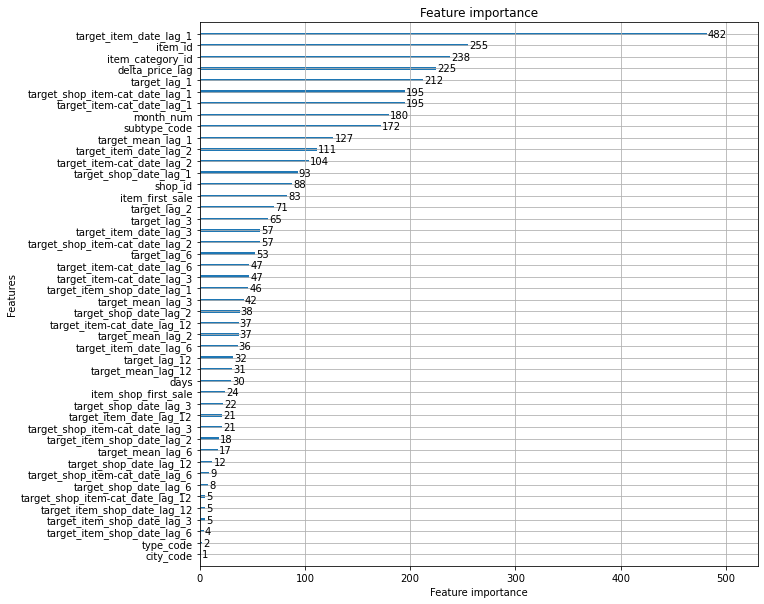

In [42]:
%%time
# LightGGM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    objective='mse',
    random_state=17
)
model_lgb.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              early_stopping_rounds=100,
              verbose=100)
pred_lgb = model_lgb.predict(X_test)

print('\nTest RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [43]:
# model_lgb.get_params()

In [44]:
all_data.sort_values(['shop_id', 'item_id', 'date_block_num'])

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
1890824,2,0,20,40,0.0,920.0,1.0,0.0,12748.0,38.0,...,0.0,0.0,0,11,4,8,0,0,30,0.000000
927141,2,1,15,76,0.0,791.0,2.0,0.0,164.0,0.0,...,0.0,0.0,0,15,31,3,0,0,30,0.000000
1580936,2,1,18,76,0.0,838.0,1.0,0.0,218.0,0.0,...,0.0,0.0,0,15,31,6,3,3,31,0.000000
4537542,2,1,19,76,0.0,956.0,1.0,0.0,254.0,0.0,...,0.0,0.0,0,15,31,7,4,4,31,0.000000
1892512,2,1,20,76,0.0,920.0,1.0,0.0,267.0,0.0,...,0.0,0.0,0,15,31,8,5,5,30,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5974079,59,22167,31,49,0.0,1214.0,29.0,0.0,571.0,4.0,...,1.0,1.0,30,12,39,7,19,19,31,0.004412
4640270,59,22167,32,49,0.0,914.0,21.0,0.0,580.0,2.0,...,2.0,2.0,30,12,39,8,20,20,30,0.004412
6188604,59,22167,33,49,0.0,790.0,37.0,0.0,639.0,1.0,...,3.0,3.0,30,12,39,9,21,21,31,0.004412
6573471,59,22167,34,49,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,30,12,39,10,22,22,30,-0.015412


In [45]:
# Too big!!!
# all_data.sort_values(['shop_id', 'item_id', 'date_block_num']).to_csv('data/all_data_sorted')